# neurosynth cognitive space

### import modules

In [1]:
# basic modules
import os
import fnmatch

import numpy as np
import pandas as pd
from scipy import stats
from sklearn import preprocessing

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

from ipywidgets import interact

%matplotlib inline

# neuroimaging modules
from nilearn import image
from nilearn import datasets
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker

from neurosynth import Dataset, dataset
from neurosynth import meta, decode, network

### get neurosynth database

This code is only necessary the first time around:

In [4]:
#dataset.download(path='../nsData/', unpack=True)
## Create a new Dataset instance
#ns_database = Dataset('../nsData/database.txt')
## Add some features
#ns_database.add_features('../nsData/features.txt')
#ns_database.save('../nsData/dataset.pkl')

This loads a previously downloaded database:

In [5]:
ns_database = Dataset.load('../nsData/dataset.pkl')

In [6]:
ns_database.activations.tail()

id                       doi     x     y     z space  peak_id  \
413424  26124716  10.3389/fnhum.2015.00340 -34.0   6.0  56.0   MNI   124801   
413425  26124716  10.3389/fnhum.2015.00340  34.0  10.0  56.0   MNI   124802   
413426  26124716  10.3389/fnhum.2015.00340 -25.0 -58.0  52.0   MNI   124803   
413427  26124716  10.3389/fnhum.2015.00340  38.0 -46.0  56.0   MNI   124804   
413428  26124716  10.3389/fnhum.2015.00340  54.0 -42.0   0.0   MNI   124805   

        table_id table_num                                              title  \
413424      6695         1  Functional networks and structural connectivit...   
413425      6695         1  Functional networks and structural connectivit...   
413426      6695         1  Functional networks and structural connectivit...   
413427      6695         1  Functional networks and structural connectivit...   
413428      6695         1  Functional networks and structural connectivit...   

                                                  authors  year  \
413424  Sala-Llonch R, Palacios EM, Junque C, Bargallo...  2015   
413425  Sala-Llonch R, Palacios EM, Junque C, Bargallo...  2015   
413426  Sala-Llonch R, Palacios EM, Junque C, Bargallo...  2015   
413427  Sala-Llonch R, Palacios EM, Junque C, Bargallo...  2015   
413428  Sala-Llonch R, Palacios EM, Junque C, Bargallo...  2015   

                                journal   i   j   k  
413424  Frontiers in human neuroscience  64  66  62  
413425  Frontiers in human neuroscience  64  68  28  
413426  Frontiers in human neuroscience  62  34  58  
413427  Frontiers in human neuroscience  64  40  26  
413428  Frontiers in human neuroscience  36  42  18

### get all features from the database

In [7]:
featureNames = ns_database.get_feature_names()

In [12]:
print featureNames[::300]

['001', 'ba 44', 'convergence', 'dysregulation', 'frontoparietal network', 'internal', 'mode', 'performing', 'regulating', 'sounds', 'underlie']


In [9]:
len(featureNames)

3169

Save all maps to file:

In [13]:
#for n,featureName in enumerate(featureNames):
#    if n%100==0: print n,featureName
#    ids = ns_database.get_studies(featureName, frequency_threshold=0.05)
#    ma = meta.MetaAnalysis(ns_database, ids)
#    ma.save_results('../nsMaps/',featureName,image_list=['pFgA_pF=0.50_FDR_0.01'])

show an example map:

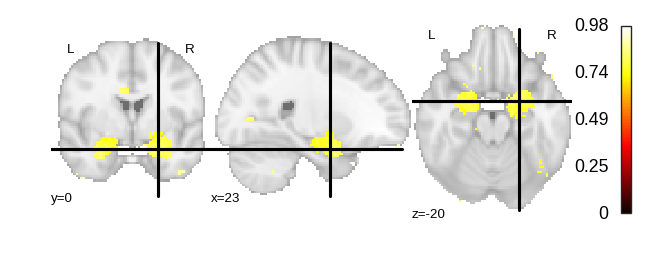

In [15]:
plotting.plot_stat_map('../nsMaps/happy_pFgA_pF=0.50_FDR_0.01.nii.gz');

### get all saved neurosynth maps and put them into a list

In [16]:
def getFile(where, what):
    
    # empty array where picture list is stored
    fileList = []
    # for all files in the folder
    for filename in os.listdir(where):
        # whenever the file matches is one of the pictures we search for
        if fnmatch.fnmatch(filename, what):
            # we append to the picture list
            fileList.append(where+filename)
    
    fileList.sort()
    # output the picture list
    return fileList

Here, we use posterior probability maps:

In [17]:
fileList = getFile('../nsMaps/','*pFgA*.nii.gz')

In [18]:
fileList[-5:]

['../nsMaps/young healthy_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/young_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/younger adults_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/younger_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/zone_pFgA_pF=0.50_FDR_0.01.nii.gz']

### initialize a masker instance

In [19]:
myMasker = NiftiMasker(detrend=False, standardize=False)

Define a mask image that is used by the masker. This will be used to extract voxel values from all subsequent maps.

In [21]:
myMasker.fit('../masks/gmMask2mm.nii')

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img=None, mask_strategy='background',
      memory=Memory(cachedir=None), memory_level=1, sample_mask=None,
      sessions=None, smoothing_fwhm=None, standardize=False, t_r=None,
      target_affine=None, target_shape=None, verbose=0)

Show the mask:

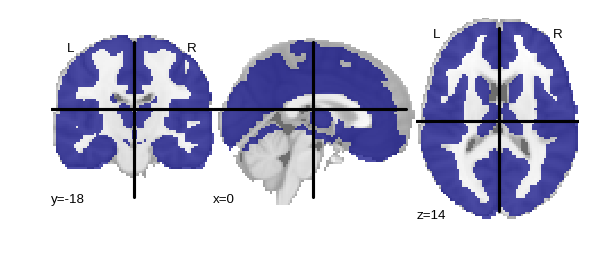

In [22]:
plotting.plot_roi(myMasker.mask_img_);

### count the above-threshold voxel for each mask  

Likely, very unspecific masks (for the pFgA maps) will have only few voxel with non-zero values (or none at all). So we can reduce the number of maps to be considered, by including only masks that have n above-zero voxel.

In [23]:
d = {}
for thisFile in fileList:
    thisArray = myMasker.transform(thisFile)
    above_thresh_voxel = np.where(thisArray>0.001)[-1].shape[0]
    fileName = thisFile.split('/')[-1]
    fileName = fileName.split('_')[0]
    d[fileName] = above_thresh_voxel

/data/martin/seminarSS17/venv/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:435: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter will change in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


In [24]:
df = pd.DataFrame(d,index=['n']).T

In [25]:
sortDf = df.sort_values(by='n',ascending=False)

In [26]:
sortDf.tail()

n
design             0
blood              0
model              0
blood oxygenation  0
neuronal           0

In [27]:
sortDf.head()

n
motor          31209
premotor       21365
movements      21142
somatosensory  17735
primary motor  17149

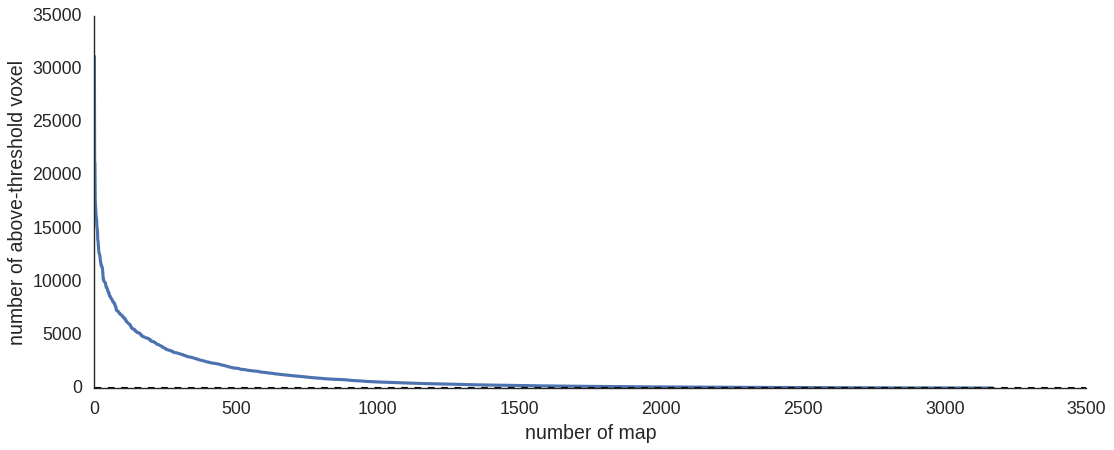

In [28]:
plt.figure(figsize=(16,6))
plt.plot(sortDf['n'].values)
plt.xlabel('number of map')
plt.ylabel('number of above-threshold voxel')
plt.axhline(100,c='k',linewidth=1,linestyle='dashed')
sns.despine()
plt.show()

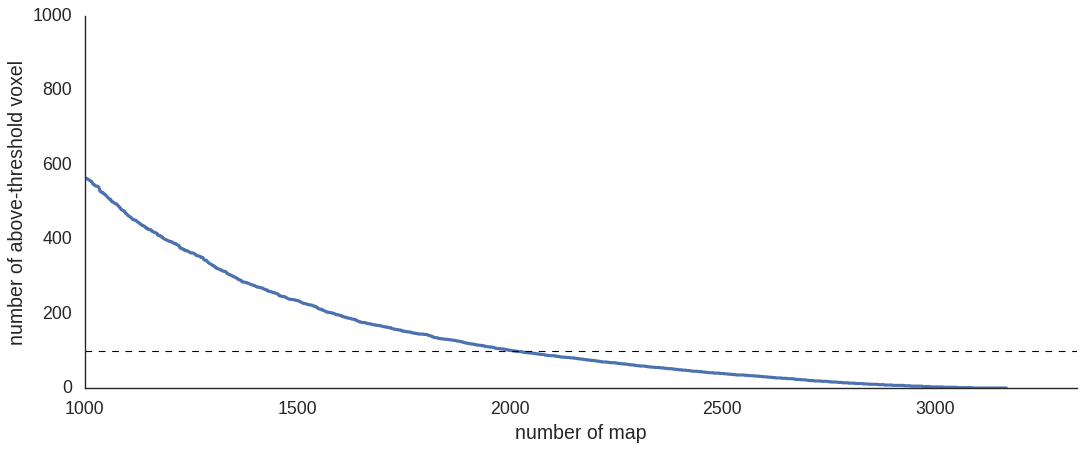

In [29]:
plt.figure(figsize=(16,6))
plt.plot(sortDf['n'].values)
plt.xlim(1000,3333)
plt.xlabel('number of map')
plt.ylim(0,1000)
plt.ylabel('number of above-threshold voxel')
plt.axhline(100,c='k',linewidth=1,linestyle='dashed')
sns.despine()
plt.show()

Get the top 2000 maps

In [30]:
selectDf = sortDf[:2000]

In [31]:
selectDf.head()

n
motor          31209
premotor       21365
movements      21142
somatosensory  17735
primary motor  17149

Example plot:

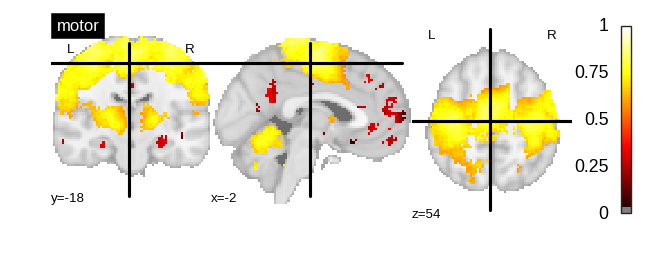

In [33]:
for featureName in selectDf.index:
    imgName = '../nsMaps/%s_pFgA_pF=0.50_FDR_0.01.nii.gz' % featureName
    plotting.plot_stat_map(imgName,threshold=0.05,title=featureName)
    plt.show()
    break

Put the filenames of the maps into a list, for looping:

In [34]:
selectList = []
for featureName in selectDf.index:
    selectList.append('../nsMaps/%s_pFgA_pF=0.50_FDR_0.01.nii.gz' % featureName)
selectList.sort()

In [36]:
len(selectList)

2000

In [35]:
selectList[-5:]

['../nsMaps/young healthy_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/young_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/younger adults_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/younger_pFgA_pF=0.50_FDR_0.01.nii.gz',
 '../nsMaps/zone_pFgA_pF=0.50_FDR_0.01.nii.gz']

### get the voxel-values for all maps and put into a df

In [37]:
def getMapFileNames(selectList,myMasker):
    # empty dict to write to
    d = {}
    # loop through all map filenames
    for n,thisFile in enumerate(selectList):
        # get the voxel values into a numpy 1d array
        thisArray = myMasker.transform(thisFile)
        # get the name of the roi
        fileName = thisFile.split('/')[-1].split('_')[0]
        # put the array into the dict
        d[fileName] = thisArray[-1]
    # make a df out of the dict
    bigDf = pd.DataFrame(d).T
    
    return bigDf

In [38]:
bigDf = getMapFileNames(selectList,myMasker)

In [39]:
bigDf.tail()

0             1             2             3       \
young adults   -2.491882e-23  1.819797e-23 -1.070372e-21  8.368741e-25   
young healthy   9.793818e-22  6.352747e-21  1.402898e-21  2.578368e-18   
younger        -3.020864e-21  3.540333e-22 -7.217151e-23 -1.307607e-19   
younger adults -1.270549e-21 -1.270549e-21 -4.235165e-22  2.168404e-19   
zone           -4.511753e-22 -2.433720e-23  2.908057e-24 -1.193001e-21   

                      4             5             6             7       \
young adults    1.434641e-24 -3.825710e-24 -9.926167e-24 -2.680065e-22   
young healthy  -5.705826e-19 -5.151019e-20  2.646978e-22 -8.291658e-21   
younger        -2.429926e-20 -3.282253e-21  1.257315e-22 -2.729696e-22   
younger adults  6.437450e-20 -6.776264e-21 -5.929231e-21 -8.470329e-22   
zone           -4.650823e-22 -1.209558e-22 -6.169927e-24  5.686867e-25   

                      8             9           ...             152669  \
young adults   -8.222175e-22 -4.235165e-22      ...       6.058452e-28   
young healthy  -2.955516e-21 -6.919366e-22      ...       1.654361e-24   
younger        -3.267363e-23  2.605619e-23      ...       1.757759e-24   
younger adults -3.176374e-22  3.970467e-23      ...       6.617445e-24   
zone           -2.274747e-24  1.964554e-24      ...       5.421011e-20   

                      152670        152671        152672        152673  \
young adults   -2.625802e-20 -6.776264e-21 -5.293956e-21  5.823352e-22   
young healthy  -7.858216e-24 -4.135903e-24 -1.033976e-25 -7.625571e-25   
younger         2.981556e-17 -4.174178e-18  1.219727e-19 -2.168404e-19   
younger adults  2.100642e-19  1.033380e-19  1.990527e-20  6.352747e-22   
zone            1.938705e-25  1.395867e-24  1.861156e-24 -7.031035e-24   

                      152674        152675        152676        152677  \
young adults    5.293956e-23  1.482308e-20  5.166901e-20  2.541099e-21   
young healthy  -1.292470e-25 -6.782881e-23 -1.902515e-23  8.271806e-25   
younger        -1.270549e-21 -1.530893e-16 -1.127570e-17  7.101524e-18   
younger adults -1.694066e-21  5.827587e-19  1.965116e-19  2.964615e-20   
zone           -5.128520e-23  5.945361e-25  3.489668e-25  1.189072e-24   

                      152678  
young adults    6.882143e-22  
young healthy   0.000000e+00  
younger        -1.124860e-18  
younger adults  3.388132e-21  
zone            1.861156e-24  

[5 rows x 152679 columns]

In [40]:
bigDf.T.describe().round(3)

01  10 healthy  14 healthy  15 healthy  18 healthy         200  \
count  152679.000  152679.000  152679.000  152679.000  152679.000  152679.000   
mean        0.001       0.001       0.004       0.002       0.002       0.002   
std         0.025       0.031       0.060       0.042       0.041       0.047   
min        -0.000      -0.000      -0.000      -0.000      -0.000      -0.000   
25%        -0.000      -0.000      -0.000      -0.000      -0.000      -0.000   
50%         0.000       0.000       0.000       0.000       0.000       0.000   
75%         0.000       0.000       0.000       0.000       0.000       0.000   
max         0.984       0.984       1.000       0.993       0.984       0.981   

             2007        2014   2014 2014  2014 wiley     ...           worse  \
count  152679.000  152679.000  152679.000  152679.000     ...      152679.000   
mean        0.002       0.001       0.001       0.001     ...           0.001   
std         0.042       0.030       0.029       0.027     ...           0.025   
min        -0.000      -0.000      -0.000      -0.000     ...          -0.000   
25%        -0.000      -0.000      -0.000      -0.000     ...          -0.000   
50%         0.000       0.000       0.000       0.000     ...           0.000   
75%         0.000       0.000       0.000       0.000     ...           0.000   
max         1.000       0.987       0.983       0.983     ...           0.982   

          written        year    year old       young  young adults  \
count  152679.000  152679.000  152679.000  152679.000    152679.000   
mean        0.014       0.001       0.003       0.003         0.003   
std         0.107       0.027       0.054       0.044         0.046   
min        -0.000      -0.000      -0.000      -0.000        -0.000   
25%        -0.000      -0.000      -0.000      -0.000        -0.000   
50%         0.000       0.000       0.000       0.000         0.000   
75%         0.000       0.000       0.000       0.000         0.000   
max         1.000       0.976       0.990       1.000         1.000   

       young healthy     younger  younger adults        zone  
count     152679.000  152679.000      152679.000  152679.000  
mean           0.007       0.004           0.006       0.003  
std            0.078       0.058           0.074       0.050  
min           -0.000      -0.000          -0.000      -0.000  
25%           -0.000      -0.000          -0.000      -0.000  
50%            0.000       0.000           0.000       0.000  
75%            0.000       0.000           0.000       0.000  
max            0.995       0.966           0.974       1.000  

[8 rows x 2000 columns]

### Standardize the maps to have mean zero, deviation one

In [41]:
from sklearn import preprocessing

In [42]:
stdDf = pd.DataFrame(preprocessing.scale(bigDf.T).T,
                     index=bigDf.index,
                     columns=bigDf.columns)

In [43]:
stdDf.tail()

0         1         2         3         4         5       \
young adults   -0.057001 -0.057001 -0.057001 -0.057001 -0.057001 -0.057001   
young healthy  -0.089289 -0.089289 -0.089289 -0.089289 -0.089289 -0.089289   
younger        -0.071860 -0.071860 -0.071860 -0.071860 -0.071860 -0.071860   
younger adults -0.086387 -0.086387 -0.086387 -0.086387 -0.086387 -0.086387   
zone           -0.056054 -0.056054 -0.056054 -0.056054 -0.056054 -0.056054   

                  6         7         8         9         ...       152669  \
young adults   -0.057001 -0.057001 -0.057001 -0.057001    ...    -0.057001   
young healthy  -0.089289 -0.089289 -0.089289 -0.089289    ...    -0.089289   
younger        -0.071860 -0.071860 -0.071860 -0.071860    ...    -0.071860   
younger adults -0.086387 -0.086387 -0.086387 -0.086387    ...    -0.086387   
zone           -0.056054 -0.056054 -0.056054 -0.056054    ...    -0.056054   

                  152670    152671    152672    152673    152674    152675  \
young adults   -0.057001 -0.057001 -0.057001 -0.057001 -0.057001 -0.057001   
young healthy  -0.089289 -0.089289 -0.089289 -0.089289 -0.089289 -0.089289   
younger        -0.071860 -0.071860 -0.071860 -0.071860 -0.071860 -0.071860   
younger adults -0.086387 -0.086387 -0.086387 -0.086387 -0.086387 -0.086387   
zone           -0.056054 -0.056054 -0.056054 -0.056054 -0.056054 -0.056054   

                  152676    152677    152678  
young adults   -0.057001 -0.057001 -0.057001  
young healthy  -0.089289 -0.089289 -0.089289  
younger        -0.071860 -0.071860 -0.071860  
younger adults -0.086387 -0.086387 -0.086387  
zone           -0.056054 -0.056054 -0.056054  

[5 rows x 152679 columns]

In [121]:
stdDf.tail()

0         1         2         3         4         5       \
young adults   -0.057001 -0.057001 -0.057001 -0.057001 -0.057001 -0.057001   
young healthy  -0.089289 -0.089289 -0.089289 -0.089289 -0.089289 -0.089289   
younger        -0.071860 -0.071860 -0.071860 -0.071860 -0.071860 -0.071860   
younger adults -0.086387 -0.086387 -0.086387 -0.086387 -0.086387 -0.086387   
zone           -0.056054 -0.056054 -0.056054 -0.056054 -0.056054 -0.056054   

                  6         7         8         9         ...       152669  \
young adults   -0.057001 -0.057001 -0.057001 -0.057001    ...    -0.057001   
young healthy  -0.089289 -0.089289 -0.089289 -0.089289    ...    -0.089289   
younger        -0.071860 -0.071860 -0.071860 -0.071860    ...    -0.071860   
younger adults -0.086387 -0.086387 -0.086387 -0.086387    ...    -0.086387   
zone           -0.056054 -0.056054 -0.056054 -0.056054    ...    -0.056054   

                  152670    152671    152672    152673    152674    152675  \
young adults   -0.057001 -0.057001 -0.057001 -0.057001 -0.057001 -0.057001   
young healthy  -0.089289 -0.089289 -0.089289 -0.089289 -0.089289 -0.089289   
younger        -0.071860 -0.071860 -0.071860 -0.071860 -0.071860 -0.071860   
younger adults -0.086387 -0.086387 -0.086387 -0.086387 -0.086387 -0.086387   
zone           -0.056054 -0.056054 -0.056054 -0.056054 -0.056054 -0.056054   

                  152676    152677    152678  
young adults   -0.057001 -0.057001 -0.057001  
young healthy  -0.089289 -0.089289 -0.089289  
younger        -0.071860 -0.071860 -0.071860  
younger adults -0.086387 -0.086387 -0.086387  
zone           -0.056054 -0.056054 -0.056054  

[5 rows x 152679 columns]

In [44]:
stdDf.T.describe()

01    10 healthy    14 healthy    15 healthy    18 healthy  \
count  1.526790e+05  1.526790e+05  1.526790e+05  1.526790e+05  1.526790e+05   
mean   2.419994e-18 -9.028438e-18 -1.414766e-17  6.515368e-18 -1.098305e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -2.801241e-02 -3.419310e-02 -6.690382e-02 -4.743749e-02 -4.606443e-02   
25%   -2.801241e-02 -3.419310e-02 -6.690382e-02 -4.743749e-02 -4.606443e-02   
50%   -2.801241e-02 -3.419310e-02 -6.690382e-02 -4.743749e-02 -4.606443e-02   
75%   -2.801241e-02 -3.419310e-02 -6.690382e-02 -4.743749e-02 -4.606443e-02   
max    3.989309e+01  3.153023e+01  1.660100e+01  2.362464e+01  2.376997e+01   

                200          2007          2014     2014 2014    2014 wiley  \
count  1.526790e+05  1.526790e+05  1.526790e+05  1.526790e+05  1.526790e+05   
mean  -2.978454e-18 -2.233840e-18 -9.679975e-18 -5.584601e-18  1.228612e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -5.288884e-02 -4.624929e-02 -3.343967e-02 -3.142438e-02 -2.949317e-02   
25%   -5.288884e-02 -4.624929e-02 -3.343967e-02 -3.142438e-02 -2.949317e-02   
50%   -5.288884e-02 -4.624929e-02 -3.343967e-02 -3.142438e-02 -2.949317e-02   
75%   -5.288884e-02 -4.624929e-02 -3.343967e-02 -3.142438e-02 -2.949317e-02   
max    2.087715e+01  2.386617e+01  3.246083e+01  3.422369e+01  3.624107e+01   

           ...              worse       written           year      year old  \
count      ...       1.526790e+05  1.526790e+05  152679.000000  1.526790e+05   
mean       ...       3.723067e-18 -5.956908e-18       0.000000 -1.693996e-17   
std        ...       1.000003e+00  1.000003e+00       1.000003  1.000003e+00   
min        ...      -2.883284e-02 -1.336526e-01      -0.030137 -5.966066e-02   
25%        ...      -2.883284e-02 -1.336526e-01      -0.030137 -5.966066e-02   
50%        ...      -2.883284e-02 -1.336526e-01      -0.030137 -5.966066e-02   
75%        ...      -2.883284e-02 -1.336526e-01      -0.030137 -5.966066e-02   
max        ...       3.866996e+01  9.246268e+00      36.435870  1.819436e+01   

              young  young adults  young healthy       younger  \
count  1.526790e+05  1.526790e+05   1.526790e+05  1.526790e+05   
mean  -3.201838e-17  3.350761e-17   3.164607e-17 -4.951679e-17   
std    1.000003e+00  1.000003e+00   1.000003e+00  1.000003e+00   
min   -5.807581e-02 -5.700132e-02  -8.928948e-02 -7.186007e-02   
25%   -5.807581e-02 -5.700132e-02  -8.928948e-02 -7.186007e-02   
50%   -5.807581e-02 -5.700132e-02  -8.928948e-02 -7.186007e-02   
75%   -5.807581e-02 -5.700132e-02  -8.928948e-02 -7.186007e-02   
max    2.263266e+01  2.154901e+01   1.265763e+01  1.644388e+01   

       younger adults          zone  
count    1.526790e+05  1.526790e+05  
mean     1.582304e-17 -1.489227e-18  
std      1.000003e+00  1.000003e+00  
min     -8.638674e-02 -5.605384e-02  
25%     -8.638674e-02 -5.605384e-02  
50%     -8.638674e-02 -5.605384e-02  
75%     -8.638674e-02 -5.605384e-02  
max      1.314018e+01  1.982074e+01  

[8 rows x 2000 columns]

In [45]:
stdDf.T.describe().round(3)

01  10 healthy  14 healthy  15 healthy  18 healthy         200  \
count  152679.000  152679.000  152679.000  152679.000  152679.000  152679.000   
mean        0.000      -0.000      -0.000       0.000      -0.000      -0.000   
std         1.000       1.000       1.000       1.000       1.000       1.000   
min        -0.028      -0.034      -0.067      -0.047      -0.046      -0.053   
25%        -0.028      -0.034      -0.067      -0.047      -0.046      -0.053   
50%        -0.028      -0.034      -0.067      -0.047      -0.046      -0.053   
75%        -0.028      -0.034      -0.067      -0.047      -0.046      -0.053   
max        39.893      31.530      16.601      23.625      23.770      20.877   

             2007        2014   2014 2014  2014 wiley     ...           worse  \
count  152679.000  152679.000  152679.000  152679.000     ...      152679.000   
mean       -0.000      -0.000      -0.000       0.000     ...           0.000   
std         1.000       1.000       1.000       1.000     ...           1.000   
min        -0.046      -0.033      -0.031      -0.029     ...          -0.029   
25%        -0.046      -0.033      -0.031      -0.029     ...          -0.029   
50%        -0.046      -0.033      -0.031      -0.029     ...          -0.029   
75%        -0.046      -0.033      -0.031      -0.029     ...          -0.029   
max        23.866      32.461      34.224      36.241     ...          38.670   

          written        year    year old       young  young adults  \
count  152679.000  152679.000  152679.000  152679.000    152679.000   
mean       -0.000       0.000      -0.000      -0.000         0.000   
std         1.000       1.000       1.000       1.000         1.000   
min        -0.134      -0.030      -0.060      -0.058        -0.057   
25%        -0.134      -0.030      -0.060      -0.058        -0.057   
50%        -0.134      -0.030      -0.060      -0.058        -0.057   
75%        -0.134      -0.030      -0.060      -0.058        -0.057   
max         9.246      36.436      18.194      22.633        21.549   

       young healthy     younger  younger adults        zone  
count     152679.000  152679.000      152679.000  152679.000  
mean           0.000      -0.000           0.000      -0.000  
std            1.000       1.000           1.000       1.000  
min           -0.089      -0.072          -0.086      -0.056  
25%           -0.089      -0.072          -0.086      -0.056  
50%           -0.089      -0.072          -0.086      -0.056  
75%           -0.089      -0.072          -0.086      -0.056  
max           12.658      16.444          13.140      19.821  

[8 rows x 2000 columns]

### Compute dissimilarity matrix from distances in space

In [46]:
from sklearn.metrics import euclidean_distances

In [47]:
dissDf = pd.DataFrame(euclidean_distances(stdDf),
                      index=stdDf.index,columns=stdDf.index)

In [48]:
dissDf.head()

01  10 healthy  14 healthy  15 healthy  18 healthy  \
01            0.000000  552.856655  551.919400  549.896687  552.948485   
10 healthy  552.856655    0.000000  551.429996  553.040054  551.737057   
14 healthy  551.919400  551.429996    0.000000  552.102426  551.114597   
15 healthy  549.896687  553.040054  552.102426    0.000000  547.350841   
18 healthy  552.948485  551.737057  551.114597  547.350841    0.000000   

                   200        2007        2014   2014 2014  2014 wiley  \
01          553.001267  552.949914  552.850827  552.835236  552.820295   
10 healthy  547.367483  549.223028  552.907902  552.888873  552.870638   
14 healthy  552.464392  549.113701  546.645184  545.206030  544.699067   
15 healthy  550.881198  537.503714  551.795118  550.390674  550.213043   
18 healthy  539.941336  538.867428  553.017511  552.991880  552.967318   

               ...           worse     written        year    year old  \
01             ...      552.815187  553.625541  552.825279  551.768258   
10 healthy     ...      552.864403  552.344522  552.876720  546.035472   
14 healthy     ...      553.124800  555.057178  550.047972  546.432243   
15 healthy     ...      552.969851  553.385344  552.986936  550.381188   
18 healthy     ...      550.115248  553.991705  552.975511  552.592522   

                 young  young adults  young healthy     younger  \
01          553.041382    543.666910     553.282718  553.147971   
10 healthy  553.140468    553.130327     553.434986  552.353959   
14 healthy  553.664580    553.038238     552.454112  552.577968   
15 healthy  553.352738    553.338674     549.855258  551.992429   
18 healthy  551.962507    547.069738     551.569112  552.423342   

            younger adults        zone  
01              548.967341  551.640544  
10 healthy      551.942055  534.652604  
14 healthy      553.095608  544.692095  
15 healthy      550.703776  553.326272  
18 healthy      552.738246  544.339462  

[5 rows x 2000 columns]

## Multi-Dimensional Scaling  

For simple visualisation in 2D space

In [49]:
from sklearn import manifold

### do the MDS with the euclidean distances between maps (dissDf)

Initialize the mds object (for 2 dimensions)

In [50]:
mds = manifold.MDS(n_components=2,
                   max_iter=10000,
                   eps=1e-9,
                   dissimilarity="precomputed",
                   n_jobs=-2)

Get positions of maps in 2D space (will be rotated differently each time around!)

In [51]:
mdsPositions = mds.fit( dissDf ).embedding_

In [52]:
mdsPositions.shape

(2000, 2)

### show data in MDS space

In [66]:
mdsDf = pd.DataFrame(mdsPositions,index=dissDf.index)

In [68]:
mdsDf.tail()

0           1
young adults    364.275675  128.940565
young healthy   205.999900 -130.875039
younger         175.243461 -394.122827
younger adults  368.669803  159.893461
zone            -57.608151 -103.347577

In [60]:
def findNeighbors(mdsDf,p,added,notCloserThan=50):
    
    # coordinates of this keyword
    thisDf = mdsDf.loc[p]
    
    # coordinates of all other keywords
    otherDf = mdsDf.drop(p)
    
    # lenghts of adjacent and opposite
    diffDf = abs(thisDf-otherDf)
    
    # lengths of hypoteneuse
    distanceDf = np.sqrt(diffDf**2).sum(axis=1)
    
    # check if there are close distances
    closeEncounters = distanceDf[distanceDf<notCloserThan].index
    
    # check if the close ones have already been labelled
    for entry in closeEncounters:
        if entry in added:
            return True
    
    return False

In [71]:
def makeMdsAnnotatedPlot(mdsDf,closest=0):
    # initialze figure
    fig = plt.figure(figsize=(18,18))
    
    # plot all positions
    plt.scatter(mdsDf[0],mdsDf[1])

    added = []
    # annoate it with the index labels from the dataframe
    for label in mdsDf.index:
        x = mdsDf.loc[label][0]
        y = mdsDf.loc[label][1]

        if not findNeighbors(mdsDf,label,added,notCloserThan=closest):
            plt.annotate(label, xy = (x, y))
            added.append(label)

    sns.despine()
    # remove the axes, as only distances are interpretable
    plt.xticks([]);plt.yticks([])
    plt.show()

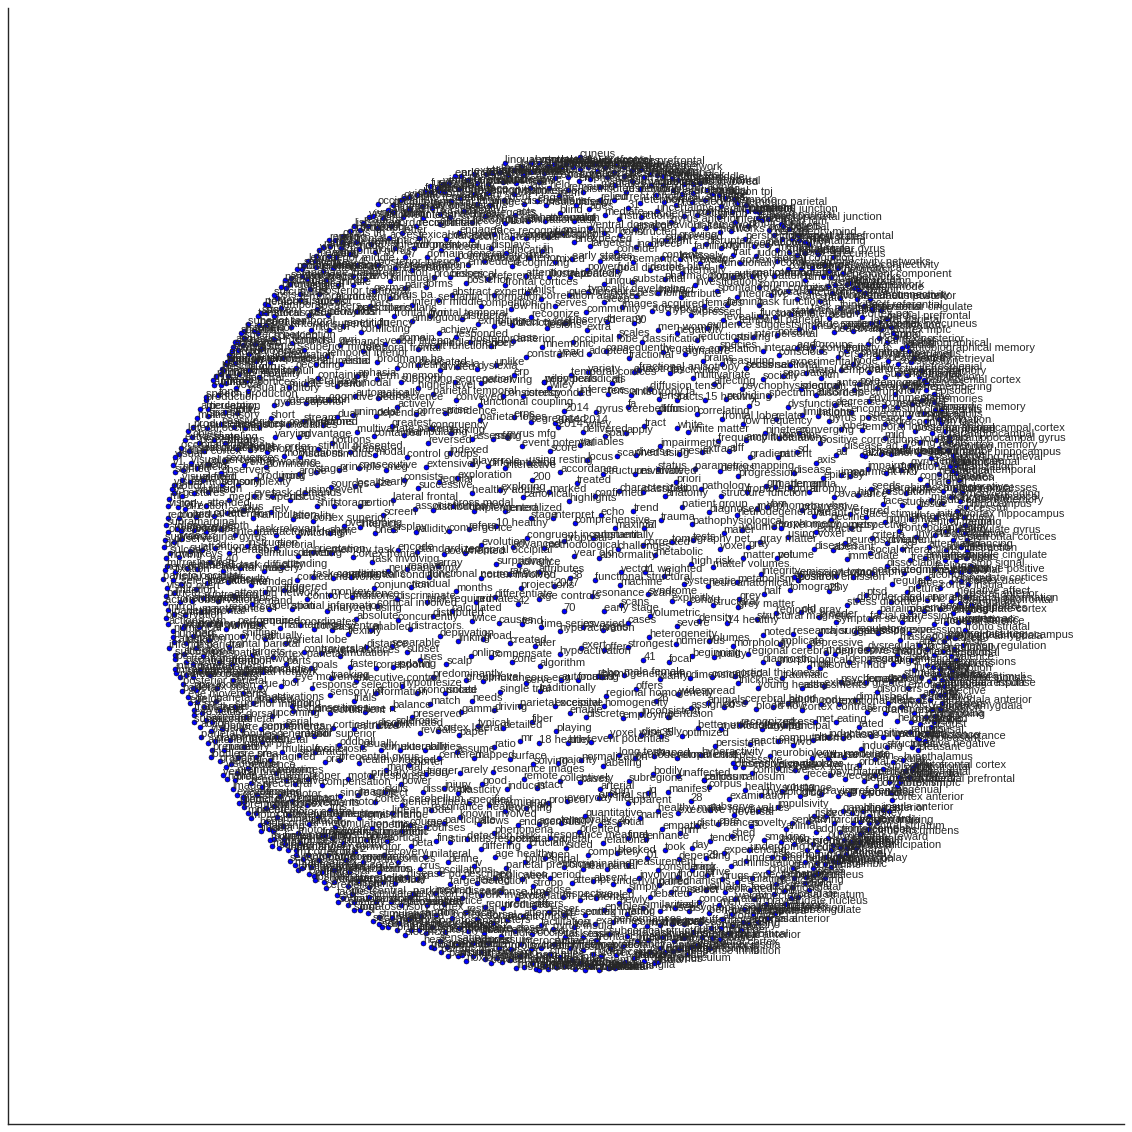

In [72]:
makeMdsAnnotatedPlot(mdsDf)

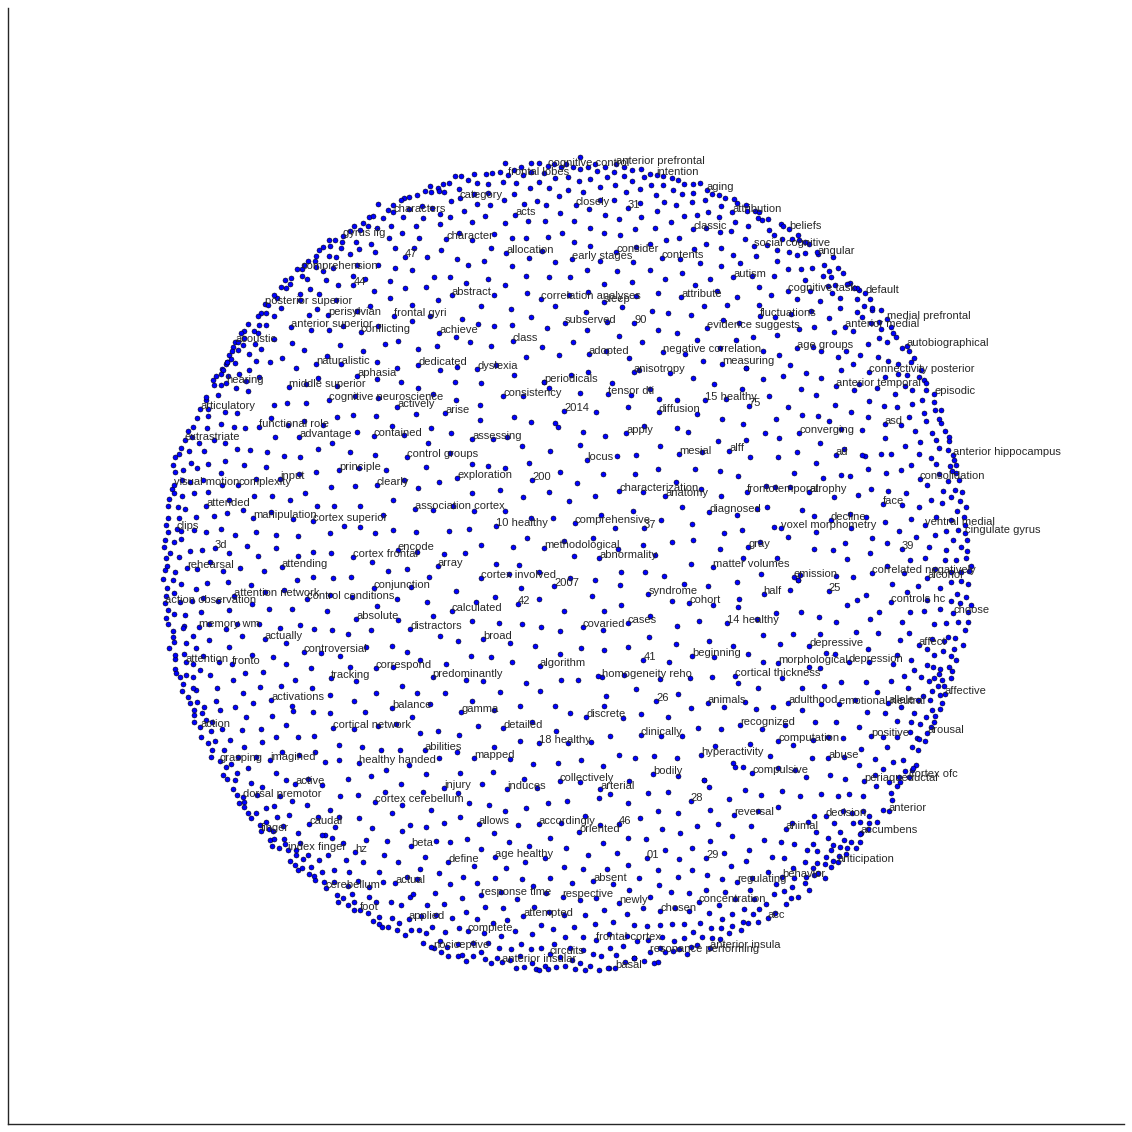

In [74]:
makeMdsAnnotatedPlot(mdsDf,closest=50)

## K-Means Clustering

In [55]:
from sklearn import cluster

### get predictions for different numbers of clusters and store in df

In [56]:
def makeKPredictions(k,stdDf):
    # initialze the cluter object for k clusters
    clf = cluster.KMeans(n_clusters=k,
                         n_jobs=-2)
    # apply to data
    clf.fit(stdDf)
    # get the predictions of group membership
    predictions = clf.fit_predict(stdDf)
    return predictions

In [76]:
def makeAllPredictions(n,stdDf):
    # empty dict to write to
    dPred = {}
    
    # do the clustering for increasing numbers of clusters
    for k in np.arange(2,n):
        # get the prediction of each map regarding the cluster is should belong to
        predictions = makeKPredictions(k,stdDf)
        # put the predictions into a dict
        dPred[k] = predictions
    # transform the dict into a table
    predDf = pd.DataFrame( dPred, index=stdDf.index)

    return predDf

In [77]:
predDf = makeAllPredictions(11,stdDf)

/data/martin/seminarSS17/venv/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data/martin/seminarSS17/venv/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data/martin/seminarSS17/venv/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead

In [78]:
predDf

2   3   4   5   6   7   8   9   10
01                  1   0   3   4   5   5   5   2   4
10 healthy          1   0   3   4   5   5   5   2   4
14 healthy          1   0   3   4   5   5   5   2   2
15 healthy          1   0   3   4   5   5   5   2   4
18 healthy          1   0   3   4   5   5   5   2   4
200                 1   0   3   4   5   5   5   2   4
2007                1   0   3   4   5   5   5   2   2
2014                1   0   3   4   5   5   5   2   2
2014 2014           1   0   3   4   5   5   5   2   2
2014 wiley          1   0   3   4   5   5   5   2   2
25                  1   0   3   4   5   5   5   2   2
26                  1   0   3   4   5   5   5   2   4
28                  1   0   3   4   5   5   5   2   4
29                  1   0   3   4   5   5   5   2   4
31                  1   0   3   4   5   5   5   2   4
34                  1   0   3   4   5   5   5   2   4
35                  1   0   3   4   5   5   5   2   4
37                  1   0   3   4   5   5   5   2   2
38                  1   0   3   4   5   5   5   2   4
39                  1   0   3   4   5   5   5   2   4
3d                  1   0   3   4   5   5   4   5   4
41                  1   0   3   4   5   5   5   2   4
42                  1   0   3   4   5   5   5   2   2
44                  1   0   3   4   3   2   6   6   4
45                  1   0   3   4   3   2   6   6   4
46                  1   0   3   4   5   5   5   2   4
47                  1   0   3   4   3   2   6   6   4
70                  1   0   3   4   5   5   5   2   2
75                  1   0   3   4   5   5   5   2   4
90                  1   0   3   4   5   5   5   2   4
...                ..  ..  ..  ..  ..  ..  ..  ..  ..
weaker              1   0   3   4   5   5   5   2   4
week                1   0   3   4   5   5   5   2   4
weight              1   0   3   4   5   5   5   2   4
whilst              1   0   3   4   5   5   5   2   4
white               1   0   3   4   5   5   5   2   2
white matter        1   0   3   4   5   5   5   2   2
wide                1   0   3   4   5   5   5   2   4
widespread          1   0   3   4   5   5   5   2   4
wiley               1   0   3   4   5   5   5   2   4
wiley periodicals   1   0   3   4   5   5   5   2   4
wm                  1   0   3   4   5   5   5   5   1
wm task             1   0   3   4   5   5   5   2   1
women               1   0   3   4   5   5   5   2   4
word                0   0   3   3   3   2   6   6   5
word form           1   0   3   4   3   2   6   6   5
word pairs          1   0   3   4   5   5   5   2   4
word recognition    1   0   3   4   3   2   6   6   5
words               0   0   0   3   3   2   6   6   6
working             1   0   3   4   5   5   5   5   1
working memory      1   0   3   4   5   5   5   5   1
worse               1   0   3   4   5   5   5   2   4
written             1   0   3   4   3   2   6   6   5
year                1   0   3   4   5   5   5   2   4
year old            1   0   3   4   5   5   5   2   2
young               1   0   3   4   5   5   5   2   2
young adults        1   0   3   4   5   5   5   2   2
young healthy       1   0   3   4   5   5   5   2   4
younger             1   0   3   4   5   5   5   2   4
younger adults      1   0   3   4   5   5   5   2   4
zone                1   0   3   4   5   5   5   2   4

[2000 rows x 9 columns]

In [172]:
predDf

2  3  4  5  6  7  8  9  10
01                 1  0  0  2  3  4  5  0   0
10 healthy         1  0  0  2  3  4  5  0   0
14 healthy         1  0  0  2  3  4  5  0   7
15 healthy         1  0  0  2  3  4  5  0   0
18 healthy         1  0  0  2  3  4  5  0   0
200                1  0  0  2  3  4  5  0   0
2007               1  0  0  2  3  4  5  0   7
2014               1  0  0  2  3  4  5  0   0
2014 2014          1  0  0  2  3  4  5  0   0
2014 wiley         1  0  0  2  3  4  5  0   0
25                 1  0  0  2  3  4  5  0   0
26                 1  0  0  2  3  4  5  0   0
28                 1  0  0  2  3  4  5  0   0
29                 1  0  0  2  3  4  5  0   0
31                 1  0  0  2  3  4  5  0   0
34                 1  0  0  2  3  4  5  0   0
35                 1  0  0  2  3  4  5  0   0
37                 1  0  0  2  3  4  5  0   7
38                 1  0  0  2  3  4  5  0   0
39                 1  0  0  2  3  4  5  0   0
3d                 1  0  0  0  3  4  5  0   0
41                 1  0  0  2  3  4  5  0   7
42                 1  0  0  2  3  4  5  0   7
44                 1  0  0  0  1  2  7  2   1
45                 1  0  0  0  1  2  7  2   1
46                 1  0  0  2  3  4  5  0   0
47                 1  0  0  0  1  2  7  2   1
70                 1  0  0  2  3  4  5  0   7
75                 1  0  0  2  3  4  5  0   0
90                 1  0  0  2  3  4  5  0   0
...               .. .. .. .. .. .. .. ..  ..
weaker             1  0  0  2  3  4  5  0   0
week               1  0  0  2  3  4  5  0   0
weight             1  0  0  2  3  4  5  0   0
whilst             1  0  0  2  3  4  5  0   0
white              1  0  0  2  3  4  5  0   0
white matter       1  0  0  2  3  4  5  0   0
wide               1  0  0  2  3  4  5  0   0
widespread         1  0  0  2  3  4  5  0   0
wiley              1  0  0  2  3  4  5  0   0
wiley periodicals  1  0  0  2  3  4  5  0   0
wm                 1  0  0  0  3  4  0  6   3
wm task            1  0  0  2  3  4  0  6   3
women              1  0  0  2  3  4  5  0   0
word               0  1  1  0  1  2  7  2   1
word form          1  0  0  0  1  2  7  2   1
word pairs         1  0  0  2  3  4  5  0   0
word recognition   1  0  0  0  1  2  7  2   1
words              0  1  1  0  1  2  7  2   1
working            1  0  0  0  3  4  0  6   3
working memory     1  0  0  0  3  4  0  6   3
worse              1  0  0  2  3  4  5  0   0
written            1  0  0  0  1  2  7  2   1
year               1  0  0  2  3  4  5  0   0
year old           1  0  0  2  3  4  5  0   7
young              1  0  0  2  3  4  5  0   0
young adults       1  0  0  2  3  4  5  0   0
young healthy      1  0  0  2  3  4  5  0   0
younger            1  0  0  2  3  4  5  0   0
younger adults     1  0  0  2  3  4  5  0   0
zone               1  0  0  2  3  4  5  0   0

[2000 rows x 9 columns]

### show predictions of clusters (from raw euclidean distances) on 2D MDS space

In [84]:
def plotKPredictions(k,mdsDf,predDf,closest=0):
    
    fig = plt.figure(figsize=(16,16))
    
    # get as many colors as there will be cluster
    myPalette = sns.color_palette('Set1',n_colors=k)
    
    # loop both trough the positions and the predictions
    for p in mdsDf.index:
        # show predictions from raw data on mds scaled data, the predictions are indicated by the color
        plt.plot(mdsDf.loc[p][0],
                 mdsDf.loc[p][1],
                 'o',color=myPalette[ predDf.loc[p][k] ] )
        
    added = []
    # annoate it with the index labels from the dataframe
    for label in mdsDf.index:
        x = mdsDf.loc[label][0]
        y = mdsDf.loc[label][1]

        if not findNeighbors(mdsDf,label,added,notCloserThan=closest):
            plt.annotate(label, xy = (x, y))
            added.append(label)

    # show the plot
    sns.despine()    
    plt.xticks([]);plt.yticks([])
    plt.show()    

array(['acoustic'], dtype=object)

In [142]:
for k in predDf.columns:
    print '\nCluster',k
    for j in np.unique(predDf[k]):
        print j
        print predDf[predDf[k]==j][::10][:10].index


Cluster 2
0
Index([u'acoustic', u'broca', u'heschl gyrus', u'listeners', u'perception',
       u'production', u'sound', u'speech sounds', u'temporal gyri', u'voice'],
      dtype='object')
1
Index([u'01', u'25', u'3d', u'aberrant', u'accordingly', u'actual',
       u'advantage', u'aging', u'ambiguous', u'anger'],
      dtype='object')

Cluster 3
0
Index([u'01', u'25', u'3d', u'aberrant', u'accordingly', u'administered',
       u'age controls', u'allele', u'amygdala hippocampus', u'animal'],
      dtype='object')
1
Index([u'action', u'contralateral primary', u'execution', u'foot', u'imagery',
       u'mirror', u'movement', u'postcentral', u'primary secondary',
       u'secondary'],
      dtype='object')
2
Index([u'acoustic', u'heard', u'modality', u'planum temporale', u'sparse',
       u'sts', u'tones'],
      dtype='object')

Cluster 4
0
Index([u'acoustic', u'comprehension', u'lexical', u'musical', u'production',
       u'spectral', u'superior temporal', u'vocal'],
      dtype='object

2


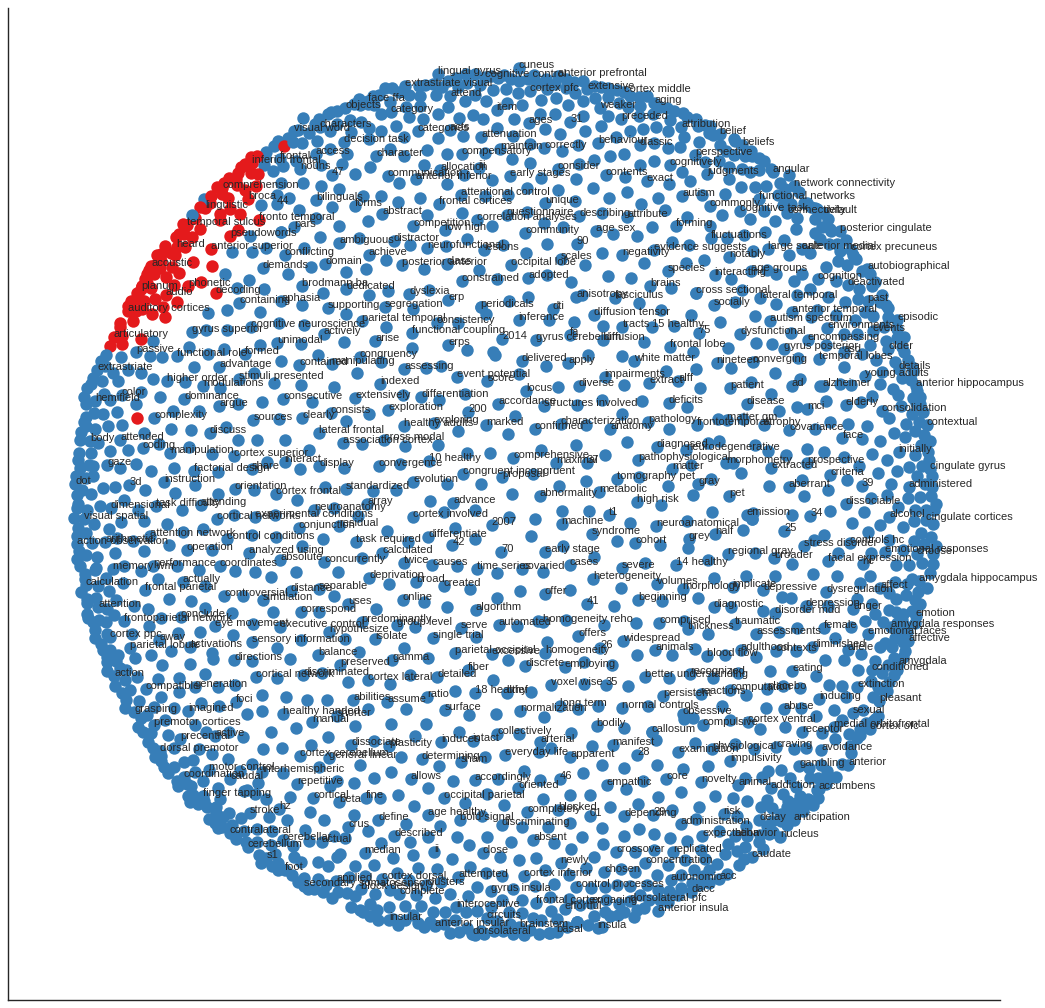

3


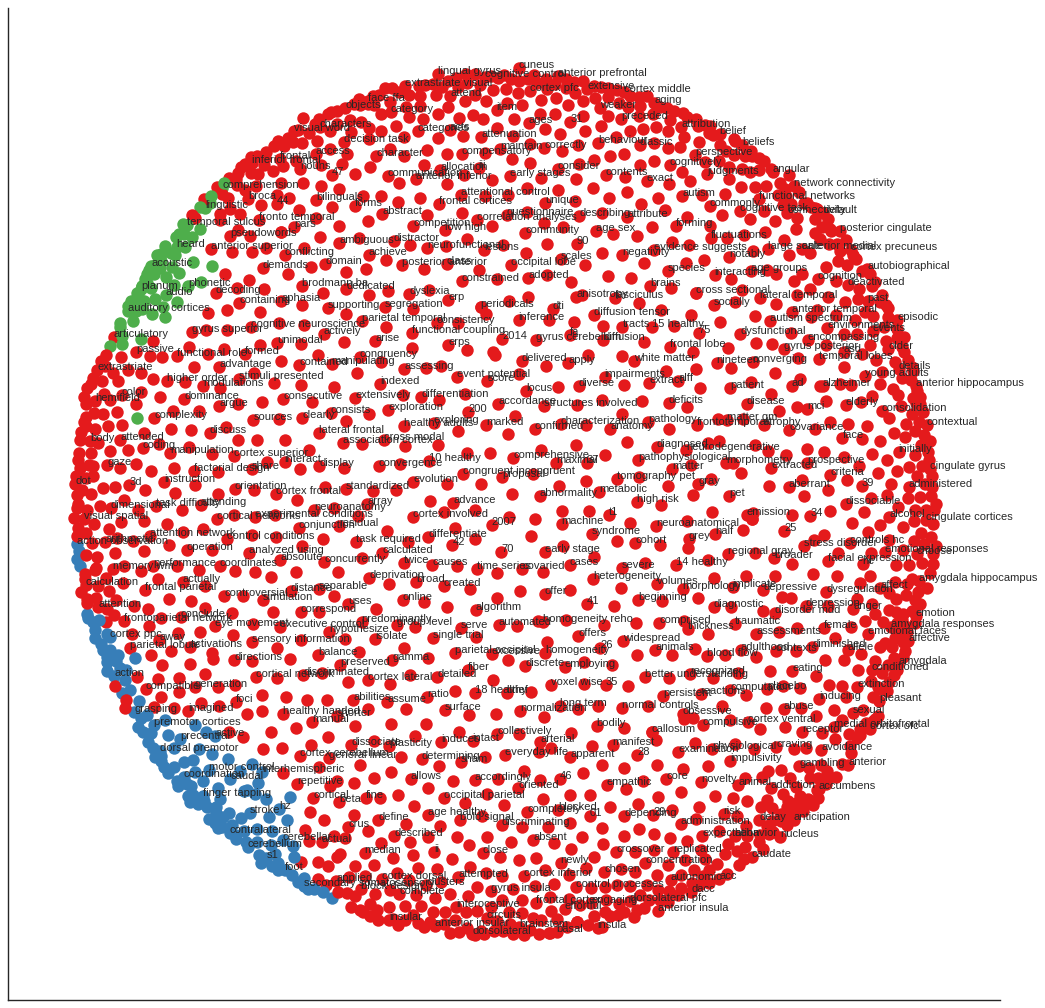

4


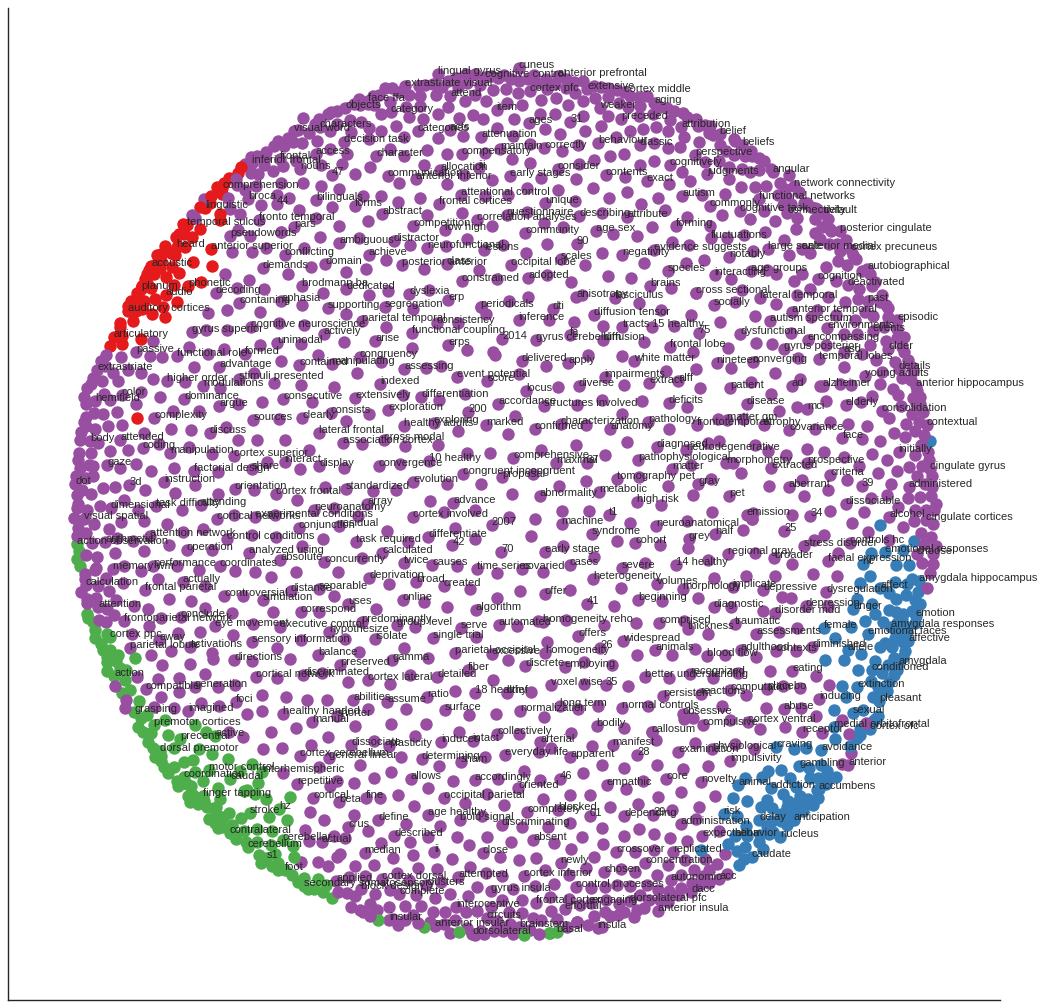

5


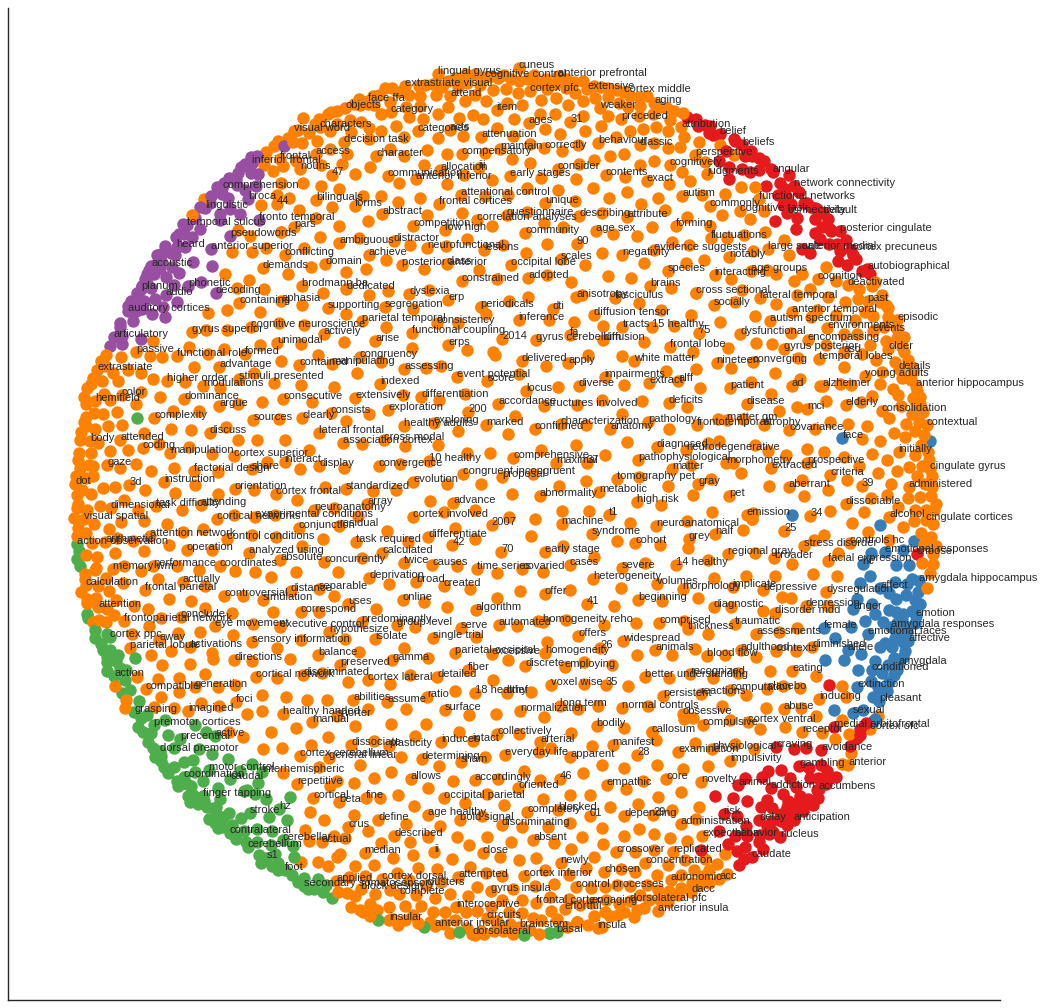

6


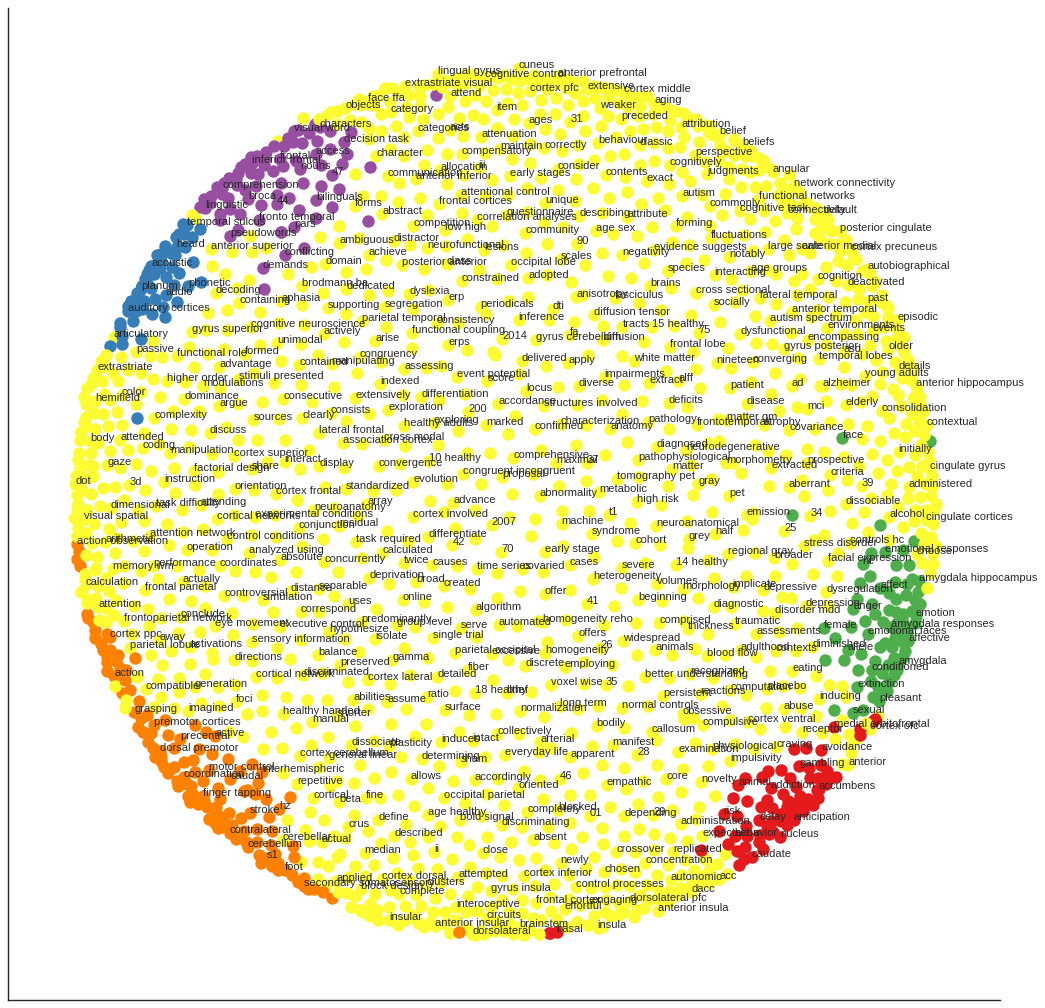

7


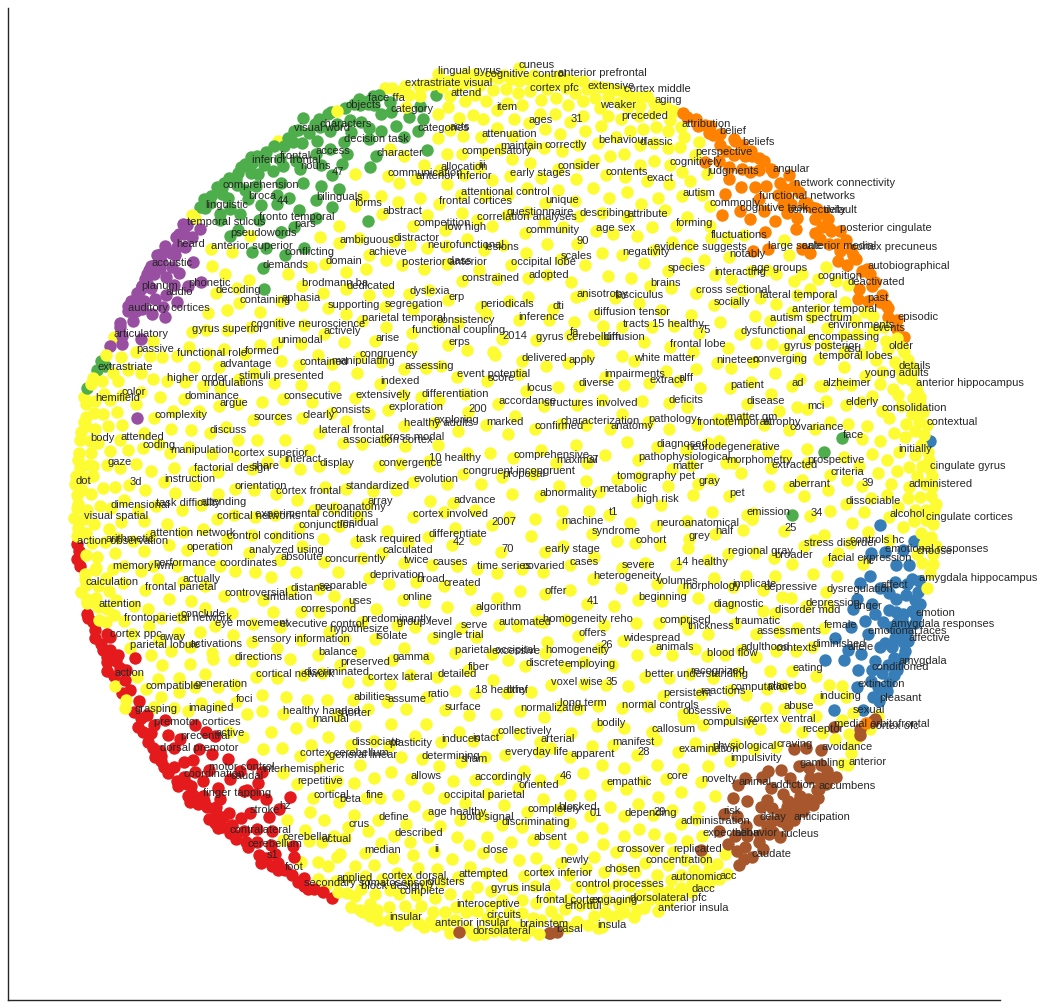

8


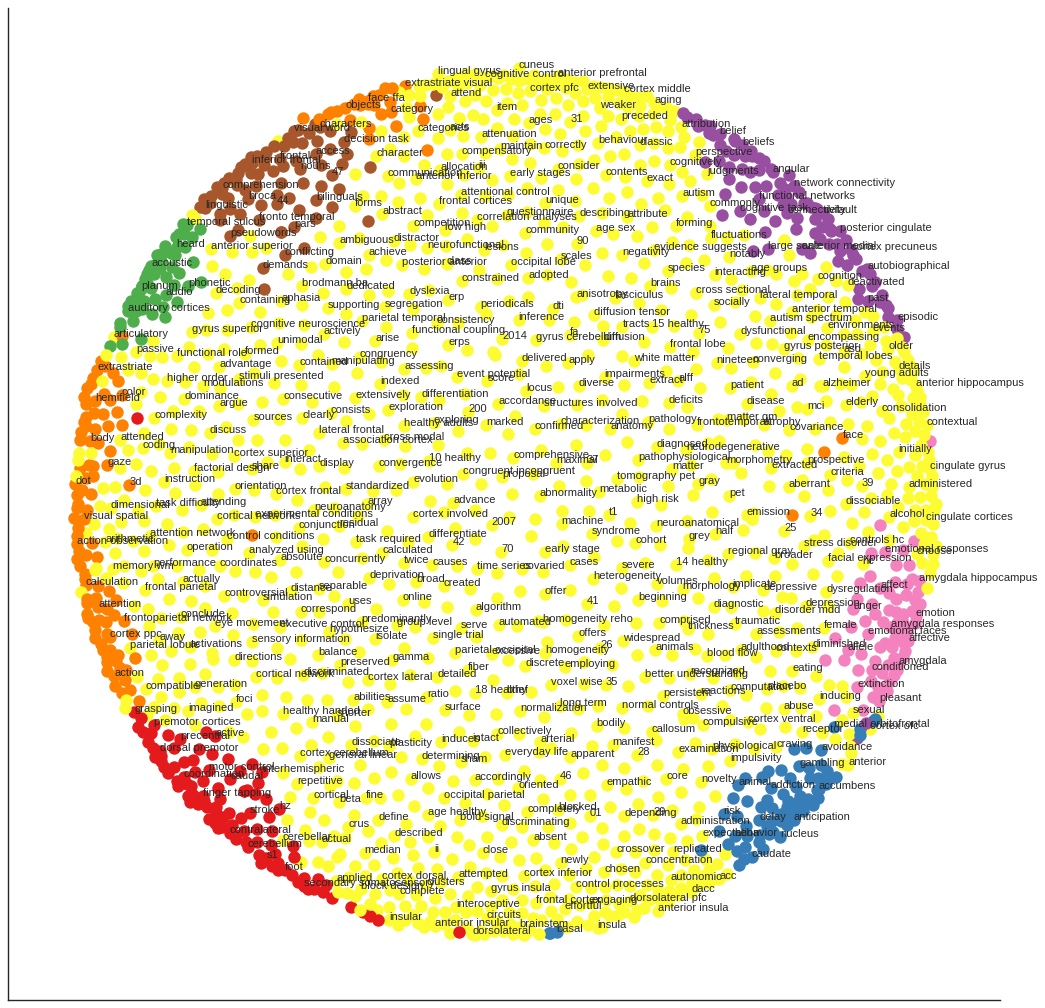

9


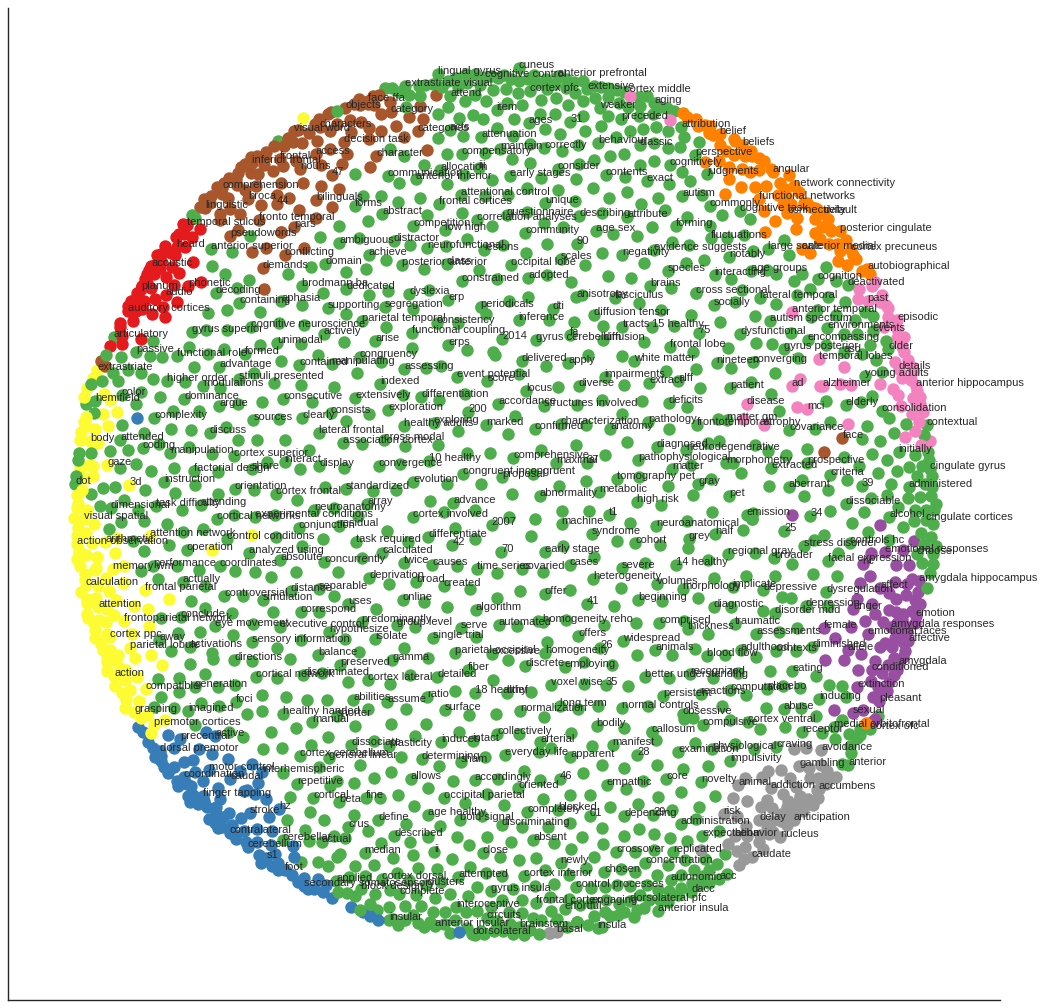

10


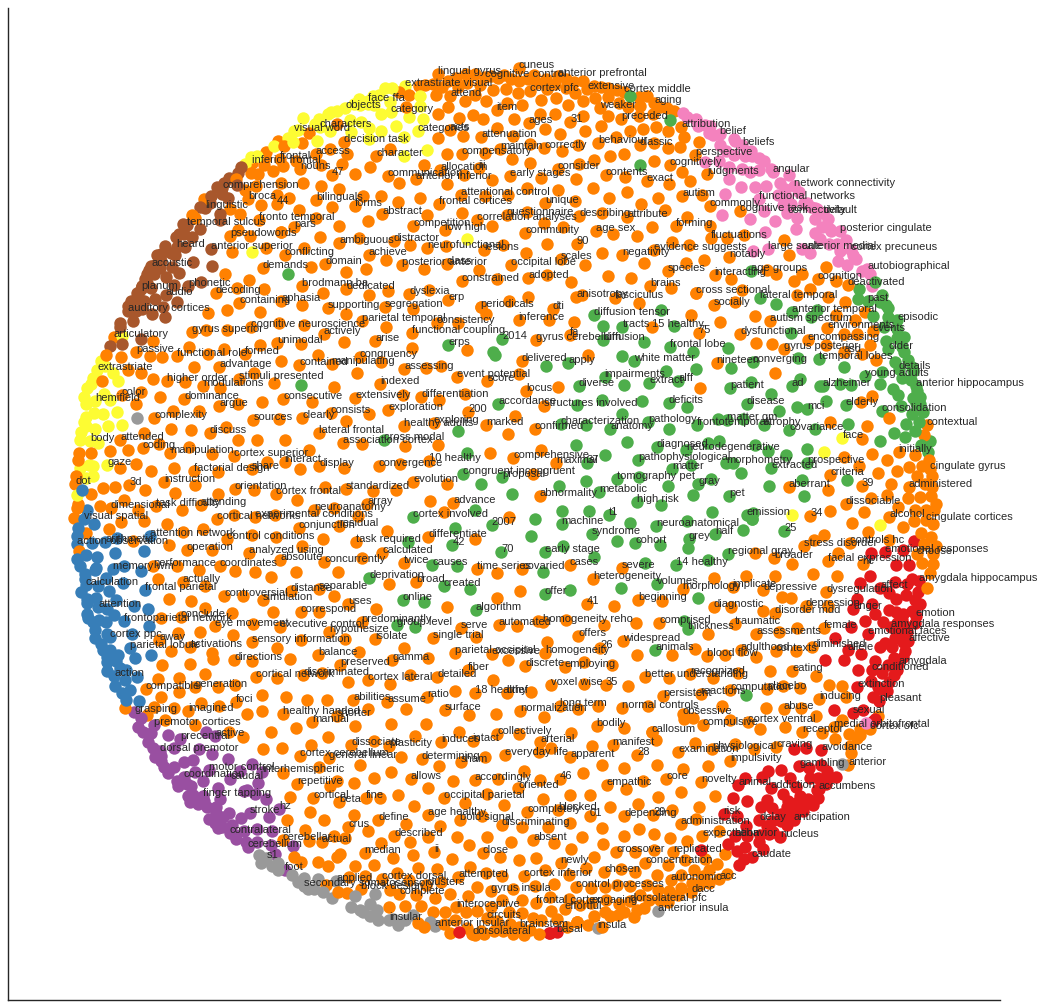

In [112]:
for i in range(2,11):
    print i
    plotKPredictions(i,mdsDf,predDf,closest=30)

## Get rid of the biggest cluster of the 9k-solution (seems unspecific)

In [96]:
def getMostFrequent(predDf,k):
    
    # get the predictions for 'k' clusters
    predArray = np.array(predDf[k])
    # get the values and their counts into a df
    predZip = pd.DataFrame( zip(np.unique(predArray),np.bincount(predArray)) )
    predZip.columns = ['idx','count']
    # sort by count
    predZip = predZip.sort_values(by='count',ascending=False)
    # show the df
    #print predZip
    # get the value of the highest count (0)
    toBeDropped = predZip.loc[predZip.index[0]]['idx']
    
    return toBeDropped

In [97]:
getMostFrequent(predDf,9)

2

In [98]:
def makeReduced(df,predDf,k):
    newDf = df.copy(deep=True)
    newDf.index = [ predDf[k],df.index ]
    newDf.columns = [ predDf[k],df.columns ]
    newDf = newDf.sort_index(axis=0)
    newDf = newDf.sort_index(axis=1)
    
    toBeDropped = getMostFrequent(predDf,k)
    newDf = newDf.drop(toBeDropped,axis=0)
    newDf = newDf.drop(toBeDropped,axis=1)
    
    newDf.index = [newDf.index.levels[1][x] for x in newDf.index.labels[1]]
    newDf.columns = [newDf.columns.levels[1][x] for x in newDf.columns.labels[1]]
    
    newDf = newDf.sort_index(axis=0)
    newDf = newDf.sort_index(axis=1)
    return newDf

In [99]:
def makeReducedStd(df,predDf,k):
    newDf = df.copy(deep=True)
    newDf.index = [ predDf[k],df.index ]
    newDf = newDf.sort_index()
    
    toBeDropped = getMostFrequent(predDf,k)
    newDf = newDf.drop(toBeDropped)
    
    newDf.index = [newDf.index.levels[1][x] for x in newDf.index.labels[1]]
    newDf = newDf.sort_index()
    
    return newDf

Example:

In [100]:
makeReduced(dissDf,predDf,9).head()

3d          44          45          47      access  \
3d        0.000000  554.152345  554.469896  553.130126  554.084440   
44      554.152345    0.000000  388.399722  522.449452  548.236530   
45      554.469896  388.399722    0.000000  477.299119  545.787825   
47      553.130126  522.449452  477.299119    0.000000  551.344734   
access  554.084440  548.236530  545.787825  551.344734    0.000000   

         accumbens    acoustic      action  action observation     actions  \
3d      556.046340  557.221689  529.519582          519.683671  529.209543   
44      555.292802  555.353310  538.798502          541.820624  542.145486   
45      555.841784  556.064851  547.643631          547.804824  548.282859   
47      554.618589  555.381663  556.384252          556.982529  555.976806   
access  555.175377  544.260571  553.794053          554.323447  555.385967   

           ...       voluntary     watched          wm        word  \
3d         ...      554.396574  544.196395  554.908928  557.368787   
44         ...      555.073580  554.011144  554.202006  482.886311   
45         ...      555.985963  554.438651  551.031788  468.342009   
47         ...      555.640487  555.101681  554.806253  511.791750   
access     ...      555.290061  550.885386  554.006136  506.160862   

         word form  word recognition       words     working  working memory  \
3d      554.385325        554.153776  558.380331  557.011944      557.045004   
44      543.584984        549.054676  492.320610  540.930137      539.735190   
45      524.691144        545.006910  478.562140  540.240837      539.196760   
47      537.457116        546.695355  509.975146  554.110722      553.921636   
access  492.126725        506.746542  504.872416  554.555709      554.762691   

           written  
3d      554.795355  
44      526.595417  
45      514.411901  
47      538.423971  
access  505.079074  

[5 rows x 662 columns]

Re-Do everything with the reduced dataset:

In [101]:
def reducedPredictions(dissDf,stdDf,predDf,k,mds=mds):
    # k-1, because we dropped one cluster
    newDissDf = makeReduced(dissDf,predDf,k-1)
    newStdDf = makeReducedStd(stdDf,predDf,k-1)

    mdsPositions = mds.fit( newDissDf ).embedding_
    mdsDf = pd.DataFrame(mdsPositions,index=newDissDf.index)
    
    kPredictions = makeKPredictions(k-1,newStdDf)
    kDf = pd.DataFrame(kPredictions,index=newStdDf.index)
    
    return newDissDf,newStdDf,mdsDf,kDf

In [102]:
newDissDf,newStdDf,newMdsDf,newKDf = reducedPredictions(dissDf,stdDf,predDf,9)

/data/martin/seminarSS17/venv/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data/martin/seminarSS17/venv/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/data/martin/seminarSS17/venv/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead

In [103]:
newStdDf.tail()

0         1         2         3         4         5       \
word             -0.229079 -0.229079 -0.229079 -0.229079 -0.229079 -0.229079   
word form        -0.164859 -0.164859 -0.164859 -0.164859 -0.164859 -0.164859   
word recognition -0.085433 -0.085433 -0.085433 -0.085433 -0.085433 -0.085433   
words            -0.258404 -0.258404 -0.258404 -0.258404 -0.258404 -0.258404   
written          -0.133653 -0.133653 -0.133653 -0.133653 -0.133653 -0.133653   

                    6         7         8         9         ...       152669  \
word              4.851412 -0.229079  4.890590  4.837314    ...    -0.229079   
word form        -0.164859 -0.164859 -0.164859 -0.164859    ...    -0.164859   
word recognition -0.085433 -0.085433 -0.085433 -0.085433    ...    -0.085433   
words            -0.258404 -0.258404  4.272012  4.224868    ...    -0.258404   
written          -0.133653  8.104010 -0.133653 -0.133653    ...    -0.133653   

                    152670    152671    152672    152673    152674    152675  \
word             -0.229079 -0.229079 -0.229079 -0.229079 -0.229079 -0.229079   
word form        -0.164859 -0.164859 -0.164859 -0.164859 -0.164859 -0.164859   
word recognition -0.085433 -0.085433 -0.085433 -0.085433 -0.085433 -0.085433   
words            -0.258404 -0.258404 -0.258404 -0.258404 -0.258404 -0.258404   
written          -0.133653 -0.133653 -0.133653 -0.133653 -0.133653 -0.133653   

                    152676    152677    152678  
word             -0.229079 -0.229079 -0.229079  
word form        -0.164859 -0.164859 -0.164859  
word recognition -0.085433 -0.085433 -0.085433  
words            -0.258404 -0.258404 -0.258404  
written          -0.133653 -0.133653 -0.133653  

[5 rows x 152679 columns]

In [104]:
newKDf.tail()

0
word              7
word form         7
word recognition  7
words             7
written           7

### save and re-load

In [105]:
#newMdsDf.to_csv('../arrays/mdsDf.csv')

In [106]:
#newDissDf.to_csv('../arrays/dissDf.csv')

In [107]:
#newKDf.columns = ['n']
#newKDf.to_csv('../arrays/kDf.csv')

In [109]:
newMdsDf = pd.read_csv('../arrays/mdsDf.csv',index_col=[0],header=0)
newMdsDf.columns = [0,1]

newKDf = pd.read_csv('../arrays/kDf.csv',index_col=[0],header=0)
newKDf.columns = ['n']

In [108]:
def plotReduced(mdsDf,kDf):
    
    plt.figure(figsize=(16,16))
    
    # get as many colors as there will be cluster
    k = np.unique(np.array(kDf['n'])).shape[0]
    myPalette = sns.color_palette('Set1',n_colors=k)
    
    kPredictions = list(kDf['n'])
    # loop both trough the positions and the predictions
    for p,l in zip(mdsDf.index,kPredictions):
        # show predictions from raw data on mds scaled data, the predictions are indicated by the color
        plt.plot(mdsDf.ix[p][0],
                 mdsDf.ix[p][1],
                 'o',color=myPalette[l] )

    # annoate it with the index labels from the dataframe
    for label, x, y in zip(mdsDf.index, mdsDf[0], mdsDf[1]):
        plt.annotate(label, xy = (x, y))

    # show the plot
    sns.despine()
    plt.xticks([]);plt.yticks([])
    plt.show() 

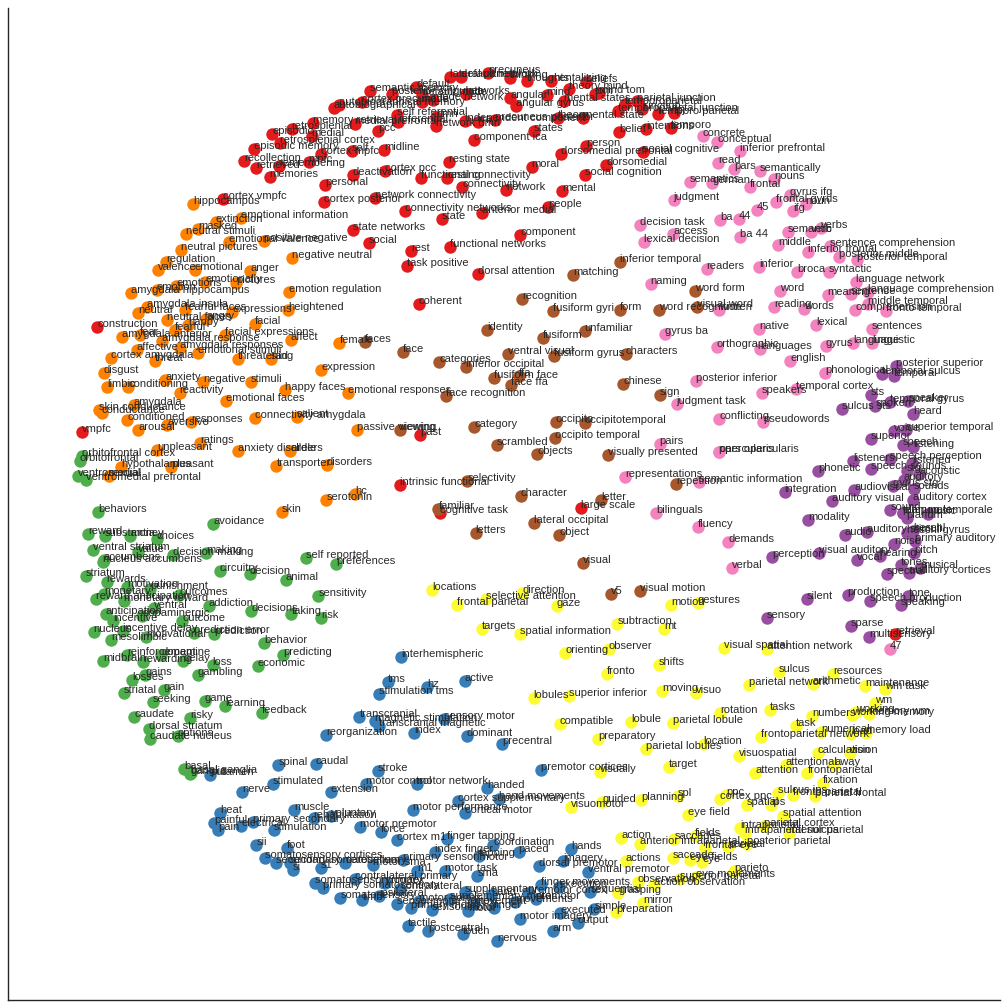

In [110]:
plotReduced(newMdsDf,newKDf)

## Make maps in 4mm resolution

### 4mm masker

In [114]:
my4mm_masker = NiftiMasker(mask_img='../masks/gmMap4mm.nii.gz',detrend=False,standardize=False).fit()

In [115]:
# load image data
def load_image(fileName):
    img = nib.load(fileName)
    image_data, image_affine = img.get_data(), img.get_affine()
    return image_data, image_affine

In [116]:
# tranform back to nifti
def transform_back(image_data,image_affine,image_name):
    array_img = nib.Nifti1Image(image_data, image_affine)
    nib.save(array_img,image_name)
    return image_name

In [117]:
def extractNs(kDf,my_masker,flip=''):
    
    nsList = []
    
    for entry in kDf.index:
        nsList.append(  '../nsMaps/%s%s_pFgA_pF=0.50_FDR_0.01.nii.gz' % tuple([flip,entry]) )
        
    nsArray = my_masker.transform(nsList)
    nsStdArray = preprocessing.scale(nsArray,axis=1)
    
    a = np.array(zip( np.array(kDf['n']), kDf.index)).T
    idx = pd.MultiIndex.from_arrays(a)
    nsStdDf = pd.DataFrame(nsStdArray,index=idx)
    nsStdDf = nsStdDf.sort_index()
    return nsStdDf

In [118]:
nsMapDf = extractNs(newKDf,my4mm_masker)

In [23]:
#nsMapDf.to_csv('../arrays/ns_4mm_database.csv')

In [120]:
clusterDict = {}
for clusterName  in ['pain','language','emotion','spatial','reward','auditory','objects','default','motor']:
    thisNum = newKDf.loc[clusterName]['n']
    clusterDict[str(thisNum)] = clusterName

In [121]:
clusterDict

{'0': 'default',
 '1': 'motor',
 '2': 'reward',
 '3': 'auditory',
 '4': 'emotion',
 '5': 'spatial',
 '6': 'objects',
 '7': 'language'}

## store as objects for use in other notebooks

In [122]:
import pickle

In [123]:
#pickle.dump( my4mm_masker, open( "../pickels/my4mm_masker.p", "wb" ) )
#pickle.dump( clusterDict, open( "../pickels/clusterDict.p", "wb" ) )